In [152]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import f1_score
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score


In [101]:
train = pd.read_csv("../Data/TaskA_train_neural_kg.csv", index_col=0)
test = pd.read_pickle("../Data/TaskA_test_neural_kg.pkl")

In [102]:
# Get entailment score
def get_entail_prob(ent_dist: str):
    s = ent_dist.strip('[]')

    # Split the string into a list of numbers
    numbers = s.split()
    # Select the last element
    last_number = numbers[-1]
    # Convert to float
    last_number = float(last_number)
    
    return last_number

def get_contrad_prob(ent_dist: str):
    s = ent_dist.strip('[]')

    # Split the string into a list of numbers
    numbers = s.split()
    # Select the first element
    first_number = numbers[0]
    # Convert to float
    first_number = float(first_number)
    
    return first_number

In [103]:
temp = train["EntailmentPtoC_distrib"][0]
get_entail_prob(temp)
get_contrad_prob(temp)
#test["topic"].value_counts()

0.00257363

In [104]:
dist_PtoC_train = train["EntailmentPtoC_distrib"]
dist_PtoC_test = test["EntailmentPtoC_distrib"]


train["contrad_prob_PtoC"] = [get_contrad_prob(s) for s in dist_PtoC_train]
train["entail_prob_PtoC"] = [get_entail_prob(s) for s in dist_PtoC_train]
test["contrad_prob_PtoC"] = [get_contrad_prob(s) for s in dist_PtoC_test]
test["entail_prob_PtoC"] = [get_entail_prob(s) for s in dist_PtoC_test]

dist_CtoP_train = train["EntailmentCtoP_distrib"]
dist_CtoP_test = test["EntailmentCtoP_distrib"]

train["contrad_prob_CtoP"] = [get_contrad_prob(s) for s in dist_CtoP_train]
train["entail_prob_CtoP"] = [get_entail_prob(s) for s in dist_CtoP_train]
test["contrad_prob_CtoP"] = [get_contrad_prob(s) for s in dist_CtoP_test]
test["entail_prob_CtoP"] = [get_entail_prob(s) for s in dist_CtoP_test]

In [105]:
train
#test_correct = pd.read_csv("../Data/TaskA_test_neural.csv")
#test_correct["topic"].value_counts()

,topic,Premise,Conclusion,Validity,Validity-Confidence,Novelty,Novelty-Confidence,EntailmentPtoC_distrib,EntailmentCtoP_distrib,SBERT_premise,...,SBERT_cosine_sim,Irrelevancy,AveDistance,SemPaths,PIds,CIds,contrad_prob_PtoC,entail_prob_PtoC,contrad_prob_CtoP,entail_prob_CtoP
0,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Depression is a well-known psychological probl...,1.0,confident,1.0,confident,[0.00257363 0.9506806 0.04674578],[1.2299823e-04 9.9849927e-01 1.3778165e-03],"tensor([ 5.9025e-01, 3.1199e-01, 3.8462e-01,...",...,0.691556,1.0,3.835000,"[{'from': 'Q289', 'to': 'Q289', 'paths': [['Q2...","{'Q1752292', 'Q1137632', 'Q6987190', 'Q9415', ...","{'Q11084414', 'Q8698', 'Q8425', 'Q9418', 'Q730...",0.002574,0.046746,0.000123,0.001378
1,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Children's TV viewing fosters negative emotions,1.0,very confident,-1.0,majority,[3.6902730e-03 9.9546152e-01 8.4823393e-04],[1.0127824e-03 9.9805212e-01 9.3512965e-04],"tensor([ 5.9025e-01, 3.1199e-01, 3.8462e-01,...",...,0.653264,1.0,3.897143,"[{'from': 'Q289', 'to': 'Q289', 'paths': [['Q2...","{'Q1752292', 'Q1137632', 'Q6987190', 'Q9415', ...","{'Q7569', 'Q1273568', 'Q6987190', 'Q9415', 'Q2...",0.003690,0.000848,0.001013,0.000935
2,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Popularity of TV is harmful to children,1.0,very confident,1.0,majority,[0.00237425 0.9916011 0.0060247 ],[1.6625022e-04 9.9832898e-01 1.5047241e-03],"tensor([ 5.9025e-01, 3.1199e-01, 3.8462e-01,...",...,0.566383,2.0,3.946667,"[{'from': 'Q289', 'to': 'Q289', 'paths': [['Q2...","{'Q1752292', 'Q1137632', 'Q6987190', 'Q9415', ...","{'Q7569', 'Q1357284', 'Q289'}",0.002374,0.006025,0.000166,0.001505
3,TV viewing is harmful to children,The popularity of TV watching is among the rea...,Violence on TV and in movies encourages psycho...,1.0,very confident,1.0,majority,[2.3087906e-04 5.8122087e-02 9.4164705e-01],[4.9157705e-05 9.9012321e-01 9.8276846e-03],"tensor([ 5.9025e-01, 3.1199e-01, 3.8462e-01,...",...,0.709627,0.0,3.840000,"[{'from': 'Q11424', 'to': 'Q11424', 'paths': [...","{'Q1752292', 'Q1137632', 'Q6987190', 'Q9415', ...","{'Q3500368', 'Q289', 'Q11424', 'Q124490'}",0.000231,0.941647,0.000049,0.009828
4,TV viewing is harmful to children,The popularity of TV watching is among the rea...,US-India deal does not cap or limit Indian fis...,-1.0,very confident,-1.0,very confident,[0.53913003 0.45541376 0.00545627],[6.5827486e-04 9.9876738e-01 5.7435635e-04],"tensor([ 5.9025e-01, 3.1199e-01, 3.8462e-01,...",...,-0.023910,4.0,3.955000,"[{'from': 'Q287171', 'to': 'Q30', 'paths': [['...","{'Q1752292', 'Q1137632', 'Q6987190', 'Q9415', ...","{'Q187939', 'Q898653', 'Q668', 'Q60140', 'Q471...",0.539130,0.005456,0.000658,0.000574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,Using sanctions to end child labor,Boycotts of one producer lead others to act ou...,Turkey’s workforce is younger than the EU-25.,-1.0,very confident,-1.0,very confident,[0.02967133 0.96572566 0.00460293],[8.2011259e-01 1.7950955e-01 3.7789016e-04],"tensor([ 2.2092e-02, 5.2591e-01, 4.3792e-01,...",...,0.003667,3.0,3.833333,"[{'from': 'Q708', 'to': 'Q43', 'paths': [['Q70...","{'Q37654', 'Q183945', 'Q595597', 'Q133080', 'Q...","{'Q43', 'Q19933476', 'Q13440398', 'Q8058602'}",0.029671,0.004603,0.820113,0.000378
746,Using sanctions to end child labor,Whilst opinion pollsters are told their interv...,9/11 terror suspects will face justice in New ...,-1.0,very confident,-1.0,very confident,[0.01450976 0.978126 0.00736422],[3.8786305e-03 9.9537551e-01 7.4592244e-04],"tensor([ 6.1543e-01, 7.9803e-01, 1.0422e-02,...",...,0.156513,4.0,3.811111,"[{'from': 'Q9465', 'to': 'Q60', 'paths': [['Q9...","{'Q140813', 'Q6821213', 'Q1939618', 'Q89640', ...","{'Q186125', 'Q9476', 'Q1384', 'Q37017', 'Q60',...",0.014510,0.007364,0.003879,0.000746
747,Using sanctions to end child labo

In [106]:
# Get 50-50 split
#n_half = int((len(train) + len(test))*0.5)

#test_set_new = train.sample(n=len(train)-n_half, random_state=42)

# Drop the selected rows from the original dataframe to update the training set
#train = train.drop(test_set_new.index)
#test = pd.concat([test, test_set_new])

In [72]:
# Only predicting validity and choosing non-embedding features
X_train = train.loc[:, ["SBERT_cosine_sim", "Irrelevancy", "AveDistance", "contrad_prob_PtoC",	"entail_prob_PtoC",	"contrad_prob_CtoP","entail_prob_CtoP"]]
                        #, "Novelty-Confidence"]]
y_train = train.loc[:, "Validity"]
X_test = test.loc[:, ["SBERT_cosine_sim", "Irrelevancy", "AveDistance", "contrad_prob_PtoC",	"entail_prob_PtoC",	"contrad_prob_CtoP","entail_prob_CtoP"]]
                      #"Novelty-Confidence"]]
y_test = test.loc[:, "Validity"]

In [158]:
def str_to_list(text):
    '''
    Return tensor string into list
    '''
    # clean string
    clean_str = text.replace('tensor(', '').replace(')', '').strip()
    # convert to list
    tensor = eval(clean_str, {"torch": torch, "__builtins__": {}})
    return tensor

def process_covariate_data(df):
    '''
    Expanding all tensors in a single cell
    Make confidence into ordinal variables
    '''
    # convert str to tensor (list)
    SBERT_premise = df.SBERT_premise.apply(lambda x: str_to_list(x))
    SBERT_conclusion = df.SBERT_conclusion.apply(lambda x: str_to_list(x))

    # expand the list into individual entries
    df_expand1 = SBERT_premise.apply(pd.Series)
    df_expand2 = SBERT_conclusion.apply(pd.Series)

    # assign a meaningful name
    df_expand1.columns = ['pre_emb{}'.format(i+1) for i in range(df_expand1.shape[1])]
    df_expand2.columns = ['con_emb{}'.format(i+1) for i in range(df_expand2.shape[1])]

    # convert confidence into ordinal variable
    confidence_mapping = {
        'very confident': 3,
        'confident': 2,
        'majority': 1,
        'defeasible': 0
    }
    df['Validity-Confidence'] = df['Validity-Confidence'].replace(confidence_mapping)
    #df["Novelty-Confidence"] = df['Novelty-Confidence'].replace(confidence_mapping)

    # put everything together
    df_final = pd.concat([df.drop(['SBERT_premise', "SBERT_conclusion"], axis=1), df_expand1, df_expand2], axis=1)
    return df_final

def preprocess_input(x, y, batchsize):
    '''
    return DataLoader for later input into the model
    '''
    # pd.dataframe to array
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    # transform y for nn model
    # assume a value of 0 is not valid/novel
    #y[y == -1] = 0

    # array to tensor
    x_torch = torch.tensor(x)
    y_torch = torch.tensor(y)
    data = TensorDataset(x_torch, y_torch)

    batch_size = batchsize
    loader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return loader

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.input_dim = 1542
        self.hidden_dim = 30
        self.output_dim = 4
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)  # Assuming n input features
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)  # Batch normalization layer
        #self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)  # Outputs 4 values, one for each output column
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.float()
        x = torch.relu(self.bn1(self.fc1(x)))
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(7, 6)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(6, 6)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        #self.layer3 = nn.Linear(256, 128)
        #self.relu3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.5)
        self.output = nn.Linear(6, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        #x = self.layer3(x)
        #x = self.relu3(x)
        #x = self.dropout3(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

model = BinaryClassifier()


In [74]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

/tmp/ipykernel_512249/1842579713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train == -1] = 0
/tmp/ipykernel_512249/1842579713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[y_test == -1] = 0


In [75]:
#X_train1 = process_covariate_data(X_train)
#X_test1 = process_covariate_data(X_test)

#X_train1

In [159]:
train_loader = preprocess_input(X_train, y_train, 16)
test_loader = preprocess_input(X_test, y_test, 16)

In [77]:
model = BinaryClassifier()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [78]:
epochs = 60
for epoch in range(epochs):
    # for each batch
    model.train()  # Set model to training mode
    total = 0
    correct = 0
    total_loss = 0
    
    all_preds = []
    all_labels = []

    for inputs, targets in train_loader:
        inputs = inputs.float()
        targets = targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to remove the extra dimension
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Get accuracy
        total_loss += loss.item()
        predicted = (outputs >= 0.5).float()  # Convert probabilities to 0 or 1
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.tolist())
        all_labels.extend(targets.tolist())
        
    accuracy = 100 * correct / total

    # Optionally print the loss every few epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        print(f"Accuracy: {accuracy}%")

conf_matrix = confusion_matrix(all_labels, all_preds)

Epoch 1, Loss: 0.6323959231376648
Accuracy: 49.13385826771653%
Epoch 6, Loss: 0.42427313327789307
Accuracy: 70.86614173228347%
Epoch 11, Loss: 0.40233078598976135
Accuracy: 71.18110236220473%
Epoch 16, Loss: 0.6715090870857239
Accuracy: 72.91338582677166%
Epoch 21, Loss: 0.516625165939331
Accuracy: 71.33858267716535%
Epoch 26, Loss: 0.30969759821891785
Accuracy: 72.75590551181102%
Epoch 31, Loss: 0.5263670086860657
Accuracy: 75.11811023622047%
Epoch 36, Loss: 0.4493201971054077
Accuracy: 73.22834645669292%
Epoch 41, Loss: 0.3890940845012665
Accuracy: 70.86614173228347%
Epoch 46, Loss: 0.9017088413238525
Accuracy: 75.11811023622047%
Epoch 51, Loss: 0.5305658578872681
Accuracy: 72.1259842519685%
Epoch 56, Loss: 0.4616049826145172
Accuracy: 72.28346456692914%


In [79]:
# Training confusion matrix
conf_matrix

array([[168, 126],
       [ 63, 278]])

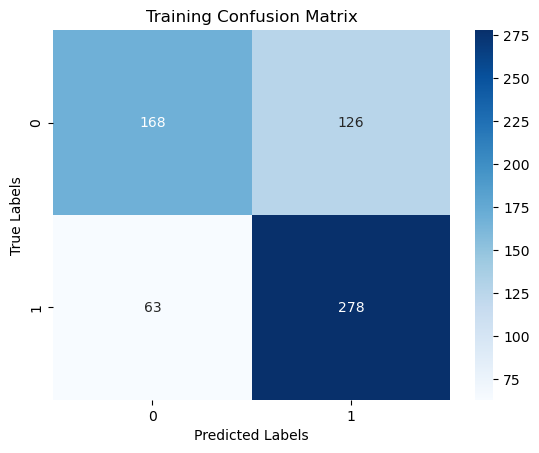

In [80]:
# Optional: Visualizing the Training confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()


In [81]:
# Remove zeros from y_tests
y_test = y_test.replace(-1, 0).astype(float)

In [82]:
def predict(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actual_labels = []
    
    with torch.no_grad():  
        for inputs, labels in data_loader:
            inputs = inputs.float()
            #labels = labels.float()
            
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            predicted_labels = (outputs.squeeze() >= 0.5).long()  # Apply threshold and convert to long dtype

            #outputs = outputs.squeeze()  # Adjusting dimensions if necessary
            #print(predicted_labels)
            #predicted_labels = (outputs >= 0.1).long()  # Applying threshold to convert to class labels
            predictions.extend(predicted_labels.tolist())
            actual_labels.extend(labels.tolist())
    
    return actual_labels, predictions


In [83]:

# Assuming test_loader is your DataLoader for the test set
actual_labels, predictions = predict(model, test_loader)


In [84]:
conf_matrix = confusion_matrix(actual_labels, predictions)

In [85]:
conf_matrix

array([[ 89, 172],
       [  8, 366]])

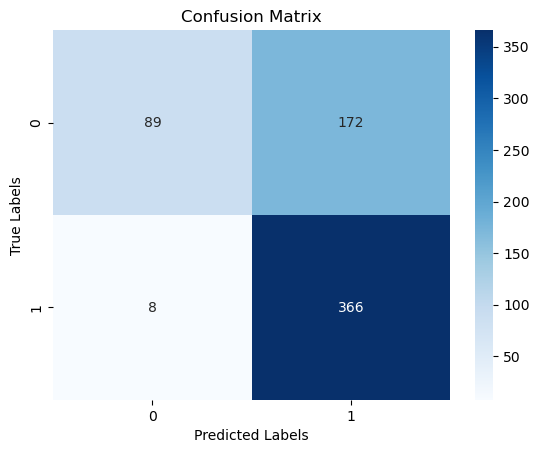

In [86]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [87]:

precision = precision_score(actual_labels, predictions)
recall = recall_score(actual_labels, predictions)
f1 = f1_score(actual_labels, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.6802973977695167
Recall: 0.9786096256684492
F1 Score: 0.8026315789473685


## Novelty Prediction

In [181]:
# Only predicting validity and choosing non-embedding features
#X_train = train.loc[:, ["SBERT_cosine_sim", "Irrelevancy", "AveDistance", "contrad_prob_PtoC","entail_prob_PtoC","contrad_prob_CtoP","entail_prob_CtoP"]]
                        #, "Novelty-Confidence"]]
X_train = train.loc[:, ["SBERT_cosine_sim", "Irrelevancy", "AveDistance", "entail_prob_PtoC"]]
y_train = train.loc[:, "Novelty"]
#X_test = test.loc[:, ["SBERT_cosine_sim", "Irrelevancy", "AveDistance", "contrad_prob_PtoC","entail_prob_PtoC",	"contrad_prob_CtoP","entail_prob_CtoP"]]
                      #"Novelty-Confidence"]]
X_test = test.loc[:, ["SBERT_cosine_sim", "Irrelevancy", "AveDistance","entail_prob_PtoC"]]
y_test = test.loc[:, "Novelty"]

In [182]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

/tmp/ipykernel_512249/1842579713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train == -1] = 0
/tmp/ipykernel_512249/1842579713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[y_test == -1] = 0


In [183]:
train_loader = preprocess_input(X_train, y_train, 32)
test_loader = preprocess_input(X_test, y_test, 32)

In [208]:
class BinaryClassifierNovelty(nn.Module):
    def __init__(self):
        super(BinaryClassifierNovelty, self).__init__()
        self.layer1 = nn.Linear(4, 6)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        #self.layer2 = nn.Linear(6, 6)
        #self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.3)
        #self.layer3 = nn.Linear(256, 128)
        #self.relu3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.5)
        self.output = nn.Linear(6, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        #x = self.layer2(x)
        #x = self.relu2(x)
        #x = self.dropout2(x)
        #x = self.layer3(x)
        #x = self.relu3(x)
        #x = self.dropout3(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [213]:
model = BinaryClassifierNovelty()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [214]:
epochs = 40
for epoch in range(epochs):
    # for each batch
    model.train()  # Set model to training mode
    total = 0
    correct = 0
    total_loss = 0
    
    all_preds = []
    all_labels = []

    for inputs, targets in train_loader:
        inputs = inputs.float()
        targets = targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the outputs to remove the extra dimension
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Get accuracy
        total_loss += loss.item()
        predicted = (outputs >= 0.3).float()  # Convert probabilities to 0 or 1
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
        # Store predictions and labels for confusion matrix
        all_preds.extend(predicted.tolist())
        all_labels.extend(targets.tolist())
        
    accuracy = 100 * correct / total

    # Optionally print the loss every few epochs
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        print(f"Accuracy: {accuracy}%")

conf_matrix = confusion_matrix(all_labels, all_preds)

Epoch 1, Loss: 0.5698233842849731
Accuracy: 32.0%
Epoch 6, Loss: 0.46554872393608093
Accuracy: 33.86666666666667%
Epoch 11, Loss: 0.6278926134109497
Accuracy: 41.333333333333336%
Epoch 16, Loss: 0.5778884291648865
Accuracy: 39.733333333333334%
Epoch 21, Loss: 0.3639715611934662
Accuracy: 41.6%
Epoch 26, Loss: 0.5467908978462219
Accuracy: 42.53333333333333%
Epoch 31, Loss: 0.5138378739356995
Accuracy: 48.666666666666664%
Epoch 36, Loss: 0.5158456563949585
Accuracy: 50.266666666666666%


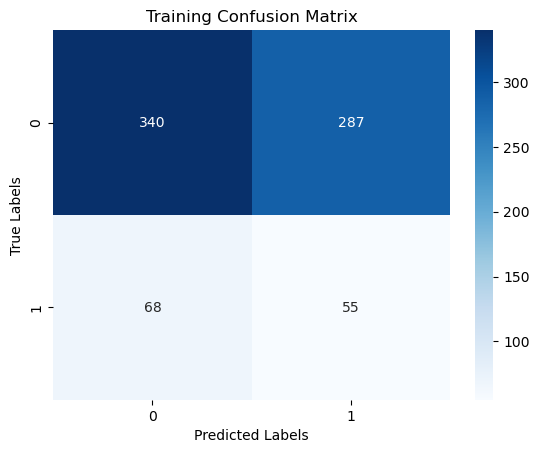

In [215]:
# Optional: Visualizing the Training confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Confusion Matrix')
plt.show()


In [216]:
y_test.value_counts()

0.0    294
1.0    226
Name: Novelty, dtype: int64

In [217]:
model

BinaryClassifierNovelty(
  (layer1): Linear(in_features=4, out_features=6, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=6, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [218]:
actual_labels, predictions = predict(model, test_loader)

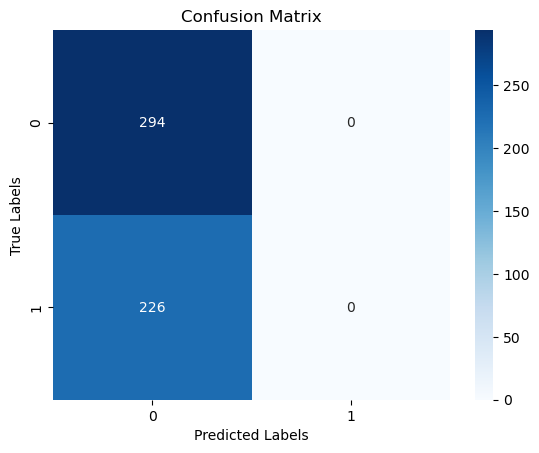

In [219]:
conf_matrix = confusion_matrix(actual_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



In [220]:

precision = precision_score(actual_labels, predictions)
recall = recall_score(actual_labels, predictions)
f1 = f1_score(actual_labels, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
